# Notebook configuration

In [1]:
run_number    = 4594, 4596, 4598, 4600, 4602, 4604, 4606, 4608, 4610, 4612, 4614, 4616, 4618, 4620, 4622, 4624, 4626, 4628, 4658
save_plots    = False
outputfolder  = "plots/{}/".format(run_number)
corr_filename = "merged_corrections.h5" #"run4236_corrections.h5"
inputfilename = "/home/brais/Documents/Next/Kr/data/{0}/dst_{0}.root.h5"

Zrange        =    0, 600
XYrange       = -198, 198
Rrange        =    0, max(XYrange)
Prange        = -3.2, 3.2  
Erange_raw    =    0, 15e3
Erange_zcorr  =  5e3, 15e3
Erange_xycorr =  9e3, 14e3
Qrange        =    0, 10e2

S1Erange      =    0, 200
S1Wrange      =    0, 400
S1Hrange      =    0, 40
S2Wrange      =    0, 100
S2Hrange      =    0, 20e3
NSirange      =    0, 30

Zrange_LT     =   50, 350
nX, nY        =   50,  0

E_norm        = {4355: 150521.1, 4358:150507.7, 4365:151030.1}

# Kr combined analysis

In [2]:
import os
import functools
import time
print("Running on ", time.asctime())

import numpy             as np
import tables            as tb
import matplotlib.pyplot as plt
import pandas            as pd 

import scipy.interpolate as spip
import matplotlib.colors as colors
from scipy.stats import argus


import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions  as fitf
import invisible_cities.reco.dst_functions  as dstf
import invisible_cities.io  .dst_io         as dstio
import invisible_cities.reco.corrections    as corrf

from invisible_cities.icaro.hst_functions import hist
from invisible_cities.icaro.hst_functions import hist2d
from invisible_cities.icaro.hst_functions import pdf
from invisible_cities.icaro.hst_functions import labels
from invisible_cities.icaro.hst_functions import hist2d_profile
from invisible_cities.icaro.hst_functions import covariance
from invisible_cities.icaro.hst_functions import resolution
from invisible_cities.icaro.hst_functions import gausstext
from invisible_cities.icaro.hst_functions import shift_to_bin_centers
from invisible_cities.icaro.hst_functions import save_to_folder

pi   = np.pi
save = functools.partial(save_to_folder, outputfolder) if save_plots else lambda *x: None

Running on  Wed Sep 13 16:47:00 2017


#### General plotting options

In [3]:
%matplotlib inline

np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

### Usefull functions

In [4]:
def crystalball(x, N, alpha, mean, sigma):
    n = 1
    absalpha = np.abs(alpha)
    A        = (n/absalpha)**(n) *np.exp(-absalpha**2/2)
    B        = n/absalpha - absalpha
    
    relation = (x-mean)/sigma

    prefun = lambda x: N*np.exp(-((x-mean)/sigma)**2/2)
    posfun = lambda x: N*A*(B-(x-mean)/sigma)**(-n)
    res = np.zeros_like(x)
    
    mask_lim_inf = relation > -alpha
    mask_lim_sup = np.logical_not(mask_lim_inf)  
    
    res[mask_lim_inf] = prefun(x[mask_lim_inf])
    res[mask_lim_sup] = posfun(x[mask_lim_sup])
    
    return res
    
def GaussExp(x, N, k, mean, sigma):
   
    relation = (x-mean)/sigma

    prefun = lambda x: N*np.exp(-(x-mean)/sigma**2/2)
    posfun = lambda x: N*np.exp(k**2/2+k*(x-mean)/sigma)
    
    res = np.zeros_like(x)
    
    mask_lim_inf = relation > - k
    mask_lim_sup = np.logical_not(mask_lim_inf)  
    
    res[mask_lim_inf] = prefun(x[mask_lim_inf])
    res[mask_lim_sup] = posfun(x[mask_lim_sup])
    
    return res

In [5]:
two_gauss   = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:-1])+args[-1]
one_gauss   = lambda x, *args: fitf.gauss(x, *args[:3]) +args[-1]
two_gauss_  = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, * args[3:6]) + args[6]*argus.pdf(x/args[8],args[7])
two_gauss_e = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, * args[3:6]) + args[6]*np.exp(-x*args[7])
two_gauss_s = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:6])
two_gauss_l = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:6])+Line_cut(x,*args[6:8],2e6)

two_crystal = lambda x, *args: crystalball(x, *args[:4]) + crystalball(x, *args[4:8])
two_expgaus = lambda x, *args: crystalball(x, *args[:4]) + crystalball(x, *args[5:10])



def Line_cut(x, a0, cutoff=1.65e5):
    res            = np.zeros_like(x)
    res[x < cutoff] = a0
    res[x > cutoff] = 0.
    return res
    
#xy_map = dstf.load_xy_corrections(corr_filename)

def plot_map(xy_map, run=""):
    x , y  = xy_map._xs
    x0, y0 = np.min(x) - np.diff(x)[0]/2, np.min(y) - np.diff(y)[0]/2
    x1, y1 = np.max(x) + np.diff(x)[0]/2, np.max(y) + np.diff(y)[0]/2
    f      = xy_map._fs
    u      = xy_map._us
    x, y   = np.repeat(x, y.size), np.tile(y, x.size)

    plt.figure(figsize=(20,8))

    plt.subplot(1, 2, 1)
    hist2d(x, y, f.shape, ((x0, x1), (y0, y1)), weights=f.flatten(), new_figure=False)
    plt.colorbar().set_label("Correction factor")
    labels("x (mm)", "y (mm)", str(run))

    plt.subplot(1, 2, 2)
    hist2d(x, y, u.shape, ((x0, x1), (y0, y1)), weights=u.flatten(), new_figure=False)
    plt.colorbar().set_label("Correction uncertainty")
    labels("x (mm)", "y (mm)", str(run))

# Read data

In [6]:
dataread = [dstf.load_dst(inputfilename.format(run), "DST", "Events") for run in run_number[:]]
print(len(dataread),len(run_number), [run for run in run_number[:]],sorted(list(E_norm.keys())) )

19 19 [4594, 4596, 4598, 4600, 4602, 4604, 4606, 4608, 4610, 4612, 4614, 4616, 4618, 4620, 4622, 4624, 4626, 4628, 4658] [4355, 4358, 4365]


In [7]:
full = pd.concat(dataread)
full = full[full.R<max(Rrange)] # soft radial cut to reduce badly reconstructed events
print(len(full))
full.head()

2739289


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,1,1.503335e+09,0,1,200.0,1.467747,9.056549,604050.0,5.809375,5035.649902,...,652012.5,7,47.9625,47.9625,-108.113247,105.379309,150.974412,2.369000,5.691396,5.722075
1,2,1.503335e+09,0,1,175.0,1.906186,10.887879,287425.0,10.731875,1670.462769,...,653512.5,14,366.0875,366.0875,-78.763789,139.821330,160.479715,2.083807,9.089066,8.807213
2,3,1.503335e+09,0,1,275.0,2.506206,13.919957,257425.0,11.242500,1405.143921,...,654537.5,8,397.1125,397.1125,-175.961949,29.215631,178.370852,2.977060,6.839425,7.680128
3,4,1.503335e+09,0,1,200.0,2.318408,13.929155,110900.0,12.321938,1250.415161,...,652987.5,7,542.0875,542.0875,69.746484,-132.886366,150.077840,-1.087461,7.731185,6.291190
4,5,1.503335e+09,0,1,325.0,2.502783,19.439775,182700.0,12.870000,1320.551392,...,654087.5,8,471.3875,471.3875,-136.227422,59.209467,148.538452,2.731588,7.150368,7.550237


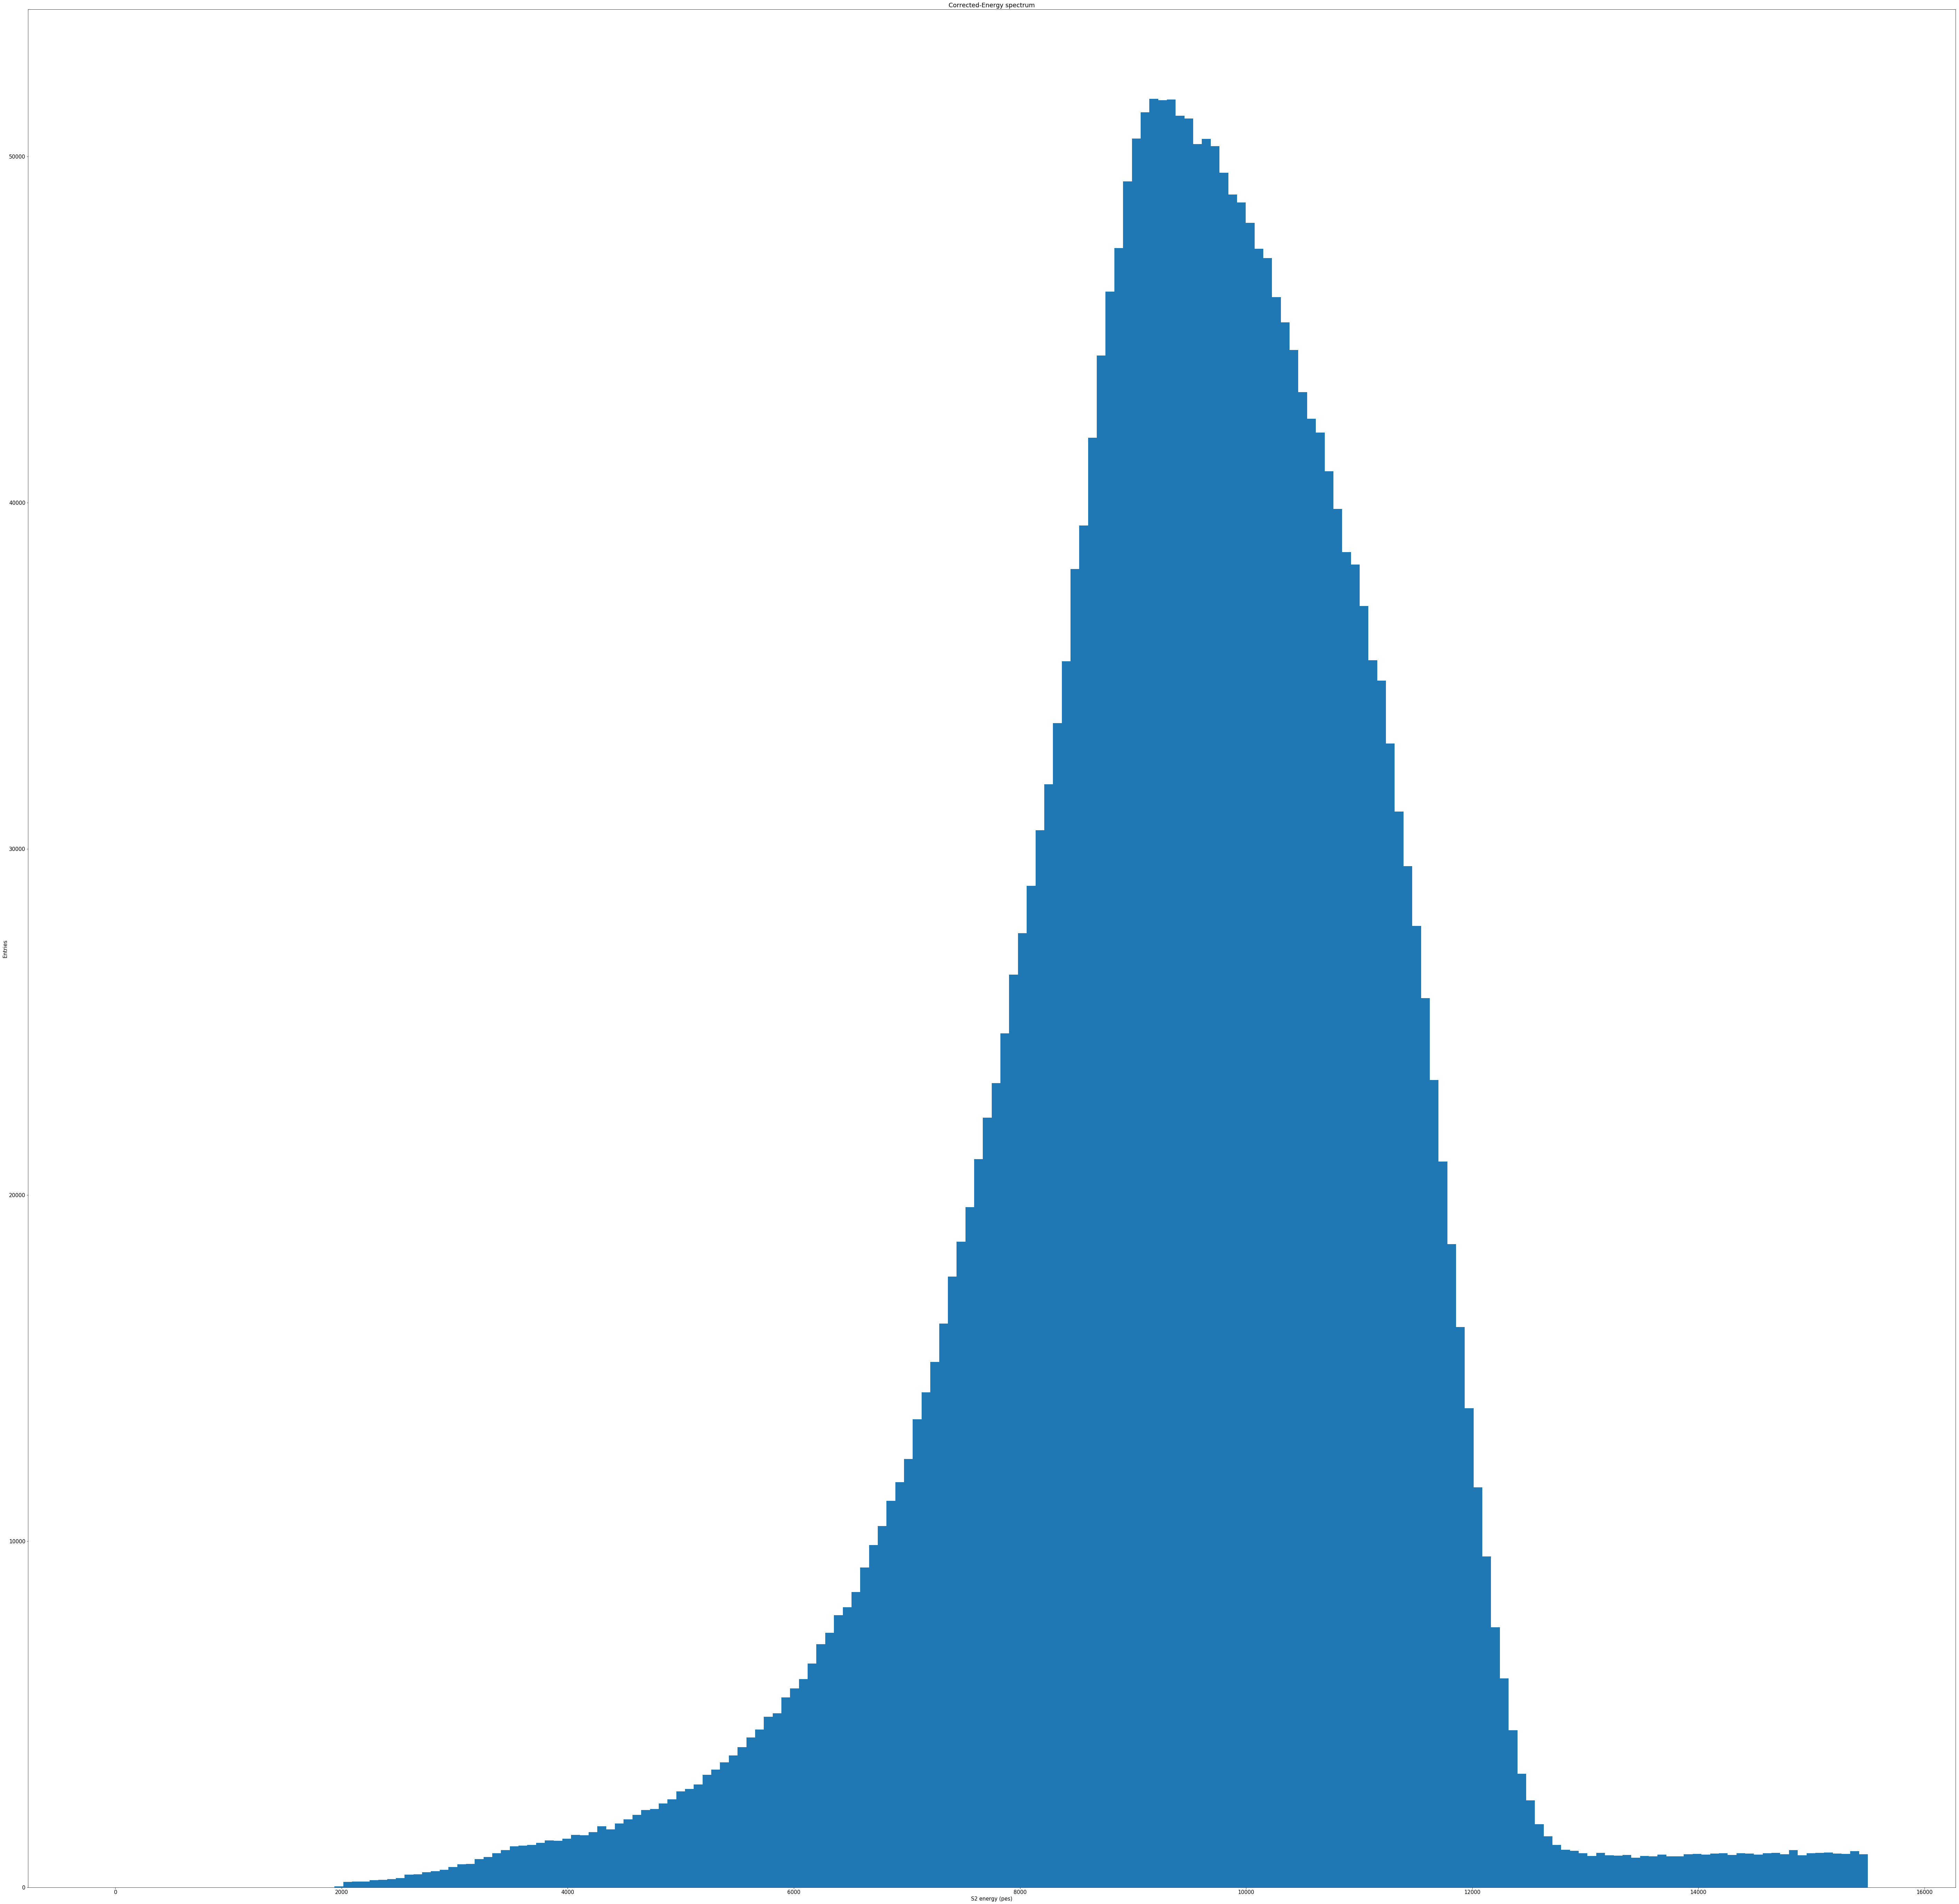

In [8]:
data = full
#data = data[fitf.in_range(data.Z, 0, 520)]
plt.figure(figsize=(100,100))
plt.hist(data.S2e, 200, (0, 1.55e4))
labels("S2 energy (pes)", "Entries", "Corrected-Energy spectrum")


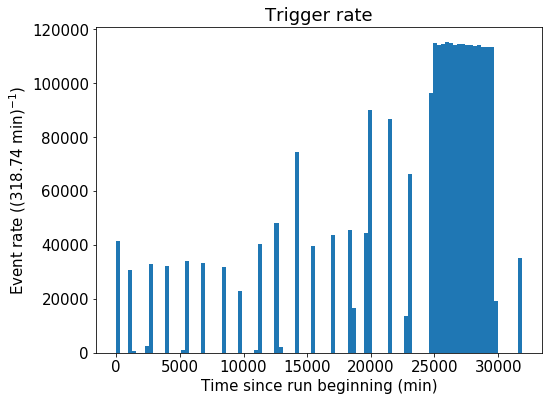

In [9]:
T       = full.time.values / 60
T      -= np.min(T)
 
y, x, _ = hist(T, 100, (np.min(T), np.max(T)))
labels("Time since run beginning (min)",
       "Event rate (({:.2f} min)$^{{-1}}$)".format(np.diff(x)[0]), "Trigger rate")

In [13]:
time = np.linspace(np.min(T), np.max(T), 500)
e0   = np.zeros_like(time)
e0e  = np.zeros_like(time)

for i in range(len(time)-1):
    data   = full[fitf.in_range(     T,time[i], time[i+1])]
    data   = data[fitf.in_range(data.Z,      0,       100)]
    e0[i]  = np.mean(data.S2e)
    e0e[i] = np.var(data.S2e**0.5)
    

(10000.0, 14000.0)

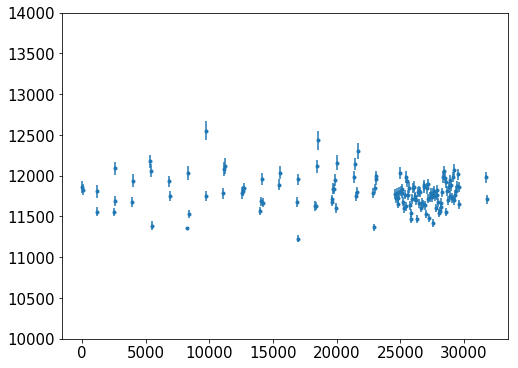

In [15]:
#plt.figure  (figsize=(100,75))
plt.errorbar(time, e0, 0.1*e0e, fmt='.')
plt.ylim    (1e4, 1.4e4 )

In [97]:
a = {'ww':5, 'tt':3}


In [102]:
b = {1:0, 2:3.5, 3:5, 4:-11}
c = {1:999}

In [105]:
{**b,**c}

{1: 999, 2: 3.5, 3: 5, 4: -11}

In [106]:
def fun(asd,ww,tt):
    asdf = ww+tt+asd
    print(asdf)
    

In [110]:
fun(-8.2,**a)

-0.1999999999999993


In [75]:
exec('asd=3')

In [76]:
asd

3

In [83]:
for key,val in a.items():
        exec(key + '=val')

In [84]:
ww

1